<div class="alert alert-success"> <b>Team Lead comment:</b>Hi! Thanks for submitting the work, it's a great project! We have everything we need) Technically everything is correctly. But most of all I enjoyed your recommendations and Tableau! Congrats on passing the final project!
   
</div>

# Sources
1. I used this to learn how to wrap texts in graphs, so I don't have rotate them in order to see the whole text - https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce

2. I used this to learn how to add a circle in the center of a pie chart - https://www.tutorialkart.com/matplotlib-tutorial/matplotlib-pyplot-bar-plot-width/#:~:text=To%20set%20width%20for%20bars%20in%2

3. I used this whenever I needed to remember a python's function parameters - www.geeksforgeeks.org/

4. I used this to learn more about panadas methods - https://pandas.pydata.org/docs/

5. Seaborn barplot documnation - https://seaborn.pydata.org/generated/seaborn.barplot.html?highlight=barplot#seaborn.barplot

# Tableau Dashboard
* https://public.tableau.com/app/profile/ameer.shehadey/viz/final_project_dashboard_16559986069860/Dashboard1

# Presentation
* https://drive.google.com/file/d/16DzfkWubWJFsEC5MBFTqy-nzHnRshckz/view?usp=sharing

## Initilization

We work for an E-commerce company, our task is to run a product range analysis - determining which products are the most profitable and most successful and which are on the other side of things.

**Purpose of the study:** Determine what line of products is the most successful in our company. Find the top sellers and highest demand items. Study our customers' purchasing behaviours and habits. All that in hopes to boost and increase the company's profits!

**Plan of Work:**
* Start with importing necessary libraries
* Loading and overviewing the datasets
* Cleaning the data from duplicates and looking for missing values
* Additional preprocessing steps if necessary
* Study popular product description keywords
* Study most profitable and high demand products
* Study the customer base
* Testing hypothesis
* Recommandations and conclusions


### Loading Libraries and Datasets
Lets start by loading necessary libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import warnings
import textwrap # add sources
warnings.filterwarnings("ignore")

I think we've got all the necessary libraries, lets continue to load the datasets:

In [2]:
df = pd.read_csv('/datasets/ecommerce_dataset_us.csv', sep='\t')
df.info(memory_usage='deep')
display(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 157.9 MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,11/29/2018 08:26,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,11/29/2018 08:26,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,11/29/2018 08:26,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,11/29/2018 08:26,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,11/29/2018 08:26,3.39,17850.0
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,11/29/2018 08:26,7.65,17850.0
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,11/29/2018 08:26,4.25,17850.0
7,536366,22633,HAND WARMER UNION JACK,6,11/29/2018 08:28,1.85,17850.0
8,536366,22632,HAND WARMER RED POLKA DOT,6,11/29/2018 08:28,1.85,17850.0
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,11/29/2018 08:34,1.69,13047.0


**Right off the bat** we can notice that the *memory_usage* is pretty high, lets work on that:

### Data Preprocessing & Optimization

Lets start by looking for duplicates:

In [3]:
print('Duplicates before dropping:', df.duplicated().sum()) # check for duplicates
df.drop_duplicates(inplace = True) 
print('Duplicates:', df.duplicated().sum()) # check for duplicates again

Duplicates before dropping: 5268
Duplicates: 0


We've found around 5000 duplicates. A duplicate in our case is a row that was repeated more than once - meaning, a row with the same InvoiceNo, CustomerId, Quantity, UnitPrice and time which doesn't make sense in our E-commerce company. Therefore, we'll drop all duplicates.

**Next:** *memory_usage* showed earlier as 157MB which is pretty high and may cause some run-times delays, so lets optimize our dataframe.

In [4]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536641 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    536641 non-null  object        
 1   StockCode    536641 non-null  object        
 2   Description  535187 non-null  object        
 3   Quantity     536641 non-null  int64         
 4   InvoiceDate  536641 non-null  datetime64[ns]
 5   UnitPrice    536641 non-null  float64       
 6   CustomerID   401604 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 127.2 MB


We've cut around 30MBs by just converting our dates into datetime. Lets move on to see if we can do more about that:

**Next:** we're dividing our dataframe into 3 parts - while working with the dataframe, we noticed that we have data about returns, purchases and adjusts; therefore, we will divide the data into 3 dataframes for easier and faster use later on.

In [5]:
# Keeping only purchases (Numerical InvoiceNos)
invoices = df[~((df['InvoiceNo'].str.startswith('C')) | (df['InvoiceNo'].str.startswith('A')))]
invoices.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850.0


In [6]:
# Keeping only returns/cancellations, InvoiceNo includes C
returns = df[df['InvoiceNo'].str.startswith('C')]
returns.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
141,C536379,D,Discount,-1,2018-11-29 09:41:00,27.50,14527.0
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2018-11-29 09:49:00,4.65,15311.0
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2018-11-29 10:24:00,1.65,17548.0
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2018-11-29 10:24:00,0.29,17548.0
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2018-11-29 10:24:00,0.29,17548.0


In [7]:
# Adjusts only, InvoiceNo includes A
adjusts = df[df['InvoiceNo'].str.startswith('A')]
adjusts

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
299982,A563185,B,Adjust bad debt,1,2019-08-10 14:50:00,11062.06,NaN
299983,A563186,B,Adjust bad debt,1,2019-08-10 14:51:00,-11062.06,NaN
299984,A563187,B,Adjust bad debt,1,2019-08-10 14:52:00,-11062.06,NaN


Now that we have 3 seperate dataframes now, lets continue **optimizing**:

In [8]:
invoices['InvoiceNo'] = invoices['InvoiceNo'].astype('int')

Checking for missing values within our first seperate dataframe:

In [9]:
df = df[~df['Description'].isna()] # removing empty descriptions
df = df[df['UnitPrice'] > 0] # removing items with price as 0
invoices = invoices[~invoices['Description'].isna()] # removing empty descriptions
invoices = invoices[invoices['UnitPrice'] > 0] # removing items with price as 0
invoices.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 524877 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    524877 non-null  int64         
 1   StockCode    524877 non-null  object        
 2   Description  524877 non-null  object        
 3   Quantity     524877 non-null  int64         
 4   InvoiceDate  524877 non-null  datetime64[ns]
 5   UnitPrice    524877 non-null  float64       
 6   CustomerID   392692 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 97.0 MB


### Summary
* We have around 134,000 of missing values in CustomerID - according to the team lead, this happened due to an error in the system for new users - we kept the rows because we still have InvoiceNo's in the other hand to identify the row.
* Seperated the dataset into 2 main dataframes; Invoices (purchases) and Returns
* We've cut memory_usage from 157 MB to 97 MB - 60 MB saved!
* We've dropped 5,000 duplicates and dealt with 12,000 missing values.

Our data is ready for studying, lets move on to the next **step**.

## Exploratory Data Analysis

We'll start our EDA with product range categorization. At this part, we'll exctract keywords from the product description and see which are most popular.

### Product Range Categorization

Studying popular keywords or categories is different from studying popular/successful products. I think it is important to study popular keywords because sometimes, certain categories are so vast and include so much products that we don't notice the success of its seperate products but as a collective they are very popular and without this study, we might miss this small hidden details.

Example: imagine we have a line of colored towels, 12 colors - now, each towel has an average sales of 30,000 which doesn't give those towels a ticket to the top 10 or top 50 products. But as a collective, they have 12 * 30,000 = 360,000 in sales, here we start to notice that these towels actually are top sellers, just in secrecy!

In [10]:
set_of_words = {} # we'll save desc keywords here
for row in invoices.index:
    desc = invoices.loc[row, 'Description']
    quan = invoices.loc[row, 'Quantity']
    desc = desc.split()
    for word in desc:
        if word in set_of_words.keys() and word != 'OF' and word not in '1234567890':
            set_of_words[word][0] += 1 # once a keyword shows up again we add 1 show-up
            set_of_words[word][1] += quan # calculating the cumulative quantity
        else:
            set_of_words[word] = [1,quan] # once a keyword shows for the first time, we give 1 show-up

list_of_words = [[k, v[0], v[1]] for k, v in set_of_words.items()] # saving in a list because dicts cant be sorted

In [11]:
# transforming the lists to a dataframe
popular_keywords = pd.DataFrame(data = {"Keyword":[row[0] for row in list_of_words], "Repetitions": [row[1] for row in list_of_words], "Quantity": [row[2] for row in list_of_words]})
popular_keywords_1 = popular_keywords[['Keyword', 'Repetitions']].sort_values(by='Repetitions', ascending = False).head(20)
popular_keywords_2 = popular_keywords[['Keyword', 'Quantity']].sort_values(by='Quantity', ascending = False).head(20)

display(popular_keywords_1.head())
display(popular_keywords_2.head())

,Keyword,Repetitions
22,SET,53069
111,BAG,50823
18,RED,41742
2,HEART,37841
98,RETROSPOT,34124


,Keyword,Quantity
111,BAG,603246
22,SET,453535
18,RED,434602
2,HEART,395938
98,RETROSPOT,361226


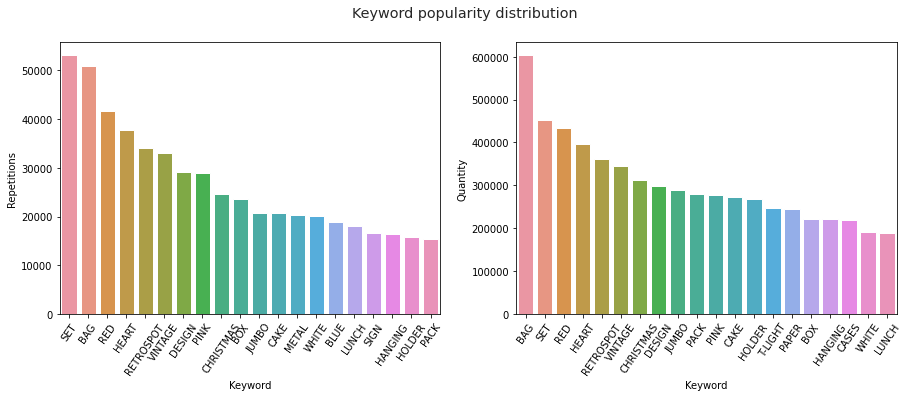

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.set_theme(style='whitegrid')
sns.barplot(data = popular_keywords_1, x = 'Keyword', y = 'Repetitions', ax=axes[0]).set_xticklabels(popular_keywords_1['Keyword'], rotation=55)
sns.barplot(data = popular_keywords_2, x = 'Keyword', y = 'Quantity', ax=axes[1]).set_xticklabels(popular_keywords_2['Keyword'], rotation=55)
axes[0].set_xlabel('Keyword')
axes[1].set_xlabel('Keyword')

axes[0].set_ylabel('Repetitions')
axes[1].set_ylabel('Quantity')

fig.suptitle('Keyword popularity distribution')
plt.show()

#### Summary
We can see that we successfully found popular keywords that appeared within the invoices.
Categories like Red, Blue, White or Metal could mean that our customers like buying stuff that are **red** or **metal** in one hand, which gives this study a reason. On the other hand, it could simply mean that a very popular product has the word **red** or **metal** in its desc and that's why those keywords appear here. For now, we are happy with the results, we have an idea of what to expect, to know more we need to continue investigation.

**Next:** Product Range Values Analysis, in this part we'll study sucessful and high demand products. Determine what is a top seller and add more information to the study we just conducted above.

### Product Range Values Analysis

We'll start our product range values analysis by looking at what products generated the most revenue (excluding returns/cancellations):

#### Products with highest sales

In [13]:
invoices_grouped = invoices.groupby(['StockCode', 'Description']).agg({'UnitPrice':'mean', 'Quantity':'sum'}).reset_index()
# ignore the math here, its basically to have the format .2f in total
invoices_grouped['Total'] = np.floor(invoices_grouped['UnitPrice'] * invoices_grouped['Quantity'] * 100)/100
invoices_grouped.sort_values(by='Total', ascending = False, inplace=True)
invoices_grouped.head(20)

,StockCode,Description,UnitPrice,Quantity,Total
4150,M,Manual,234.489652,6984,1637675.72
4149,DOT,DOTCOM POSTAGE,292.137068,706,206248.77
1340,22423,REGENCY CAKESTAND 3 TIER,13.983936,13851,193691.50
2668,23843,"PAPER CRAFT , LITTLE BIRDIE",2.080000,80995,168469.60
3619,85099B,JUMBO BAG RED RETROSPOT,2.486197,48371,120259.84
3640,85123A,WHITE HANGING HEART T-LIGHT HOLDER,3.116159,37580,117105.24
2123,23166,MEDIUM CERAMIC TOP STORAGE JAR,1.468480,78033,114589.89
2877,47566,PARTY BUNTING,5.797928,18283,106003.52
4152,POST,POSTAGE,31.076581,3150,97891.22
2029,23084,RABBIT NIGHT LIGHT,2.386401,30739,73355.58


We **notice** weird product names/stock codes like 'Manual - M' and 'DOTCOM POSTAGE - DOT'. From the name, we can guess it is some sort services that the company offers - meaning it is not a product and shouldn't be among our product line - to make sure, lets investigate a little bit more:

In [14]:
print('MANUAL DESC:')
display(invoices[invoices['StockCode'] == 'M']['UnitPrice'].describe())
print('POSTAGE DESC:')
display(invoices[invoices['StockCode'] == 'DOT']['UnitPrice'].describe())
print('AVERAGE PRODUCT DESC:')
display(invoices.query('StockCode != "M" and StockCode != "DOT" and StockCode != "POST"')['UnitPrice'].describe())

MANUAL DESC:


count     316.000000
mean      234.489652
std       654.055657
min         0.060000
25%         0.790000
50%         1.950000
75%        40.460000
max      4287.630000
Name: UnitPrice, dtype: float64

POSTAGE DESC:


count     706.000000
mean      292.137068
std       355.726548
min         0.350000
25%       131.607500
50%       185.470000
75%       265.055000
max      4505.170000
Name: UnitPrice, dtype: float64

AVERAGE PRODUCT DESC:


count    522729.000000
mean          3.314280
std          19.252152
min           0.001000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64

Comparing the data above, we can see that more than 95% of the products sold in the company are below a 100USD while 'Manual' and 'POSTAGE' have items that cost over 4000 which confirms that these items are nothing but services that the company offers. Therefore, we can drop them from our dataframe since they aren't a product.

In [15]:
# this function wraps text instead of having to rotate it to be able to see the whole text
def wrap_labels(ax, width, break_long_words=False): # https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

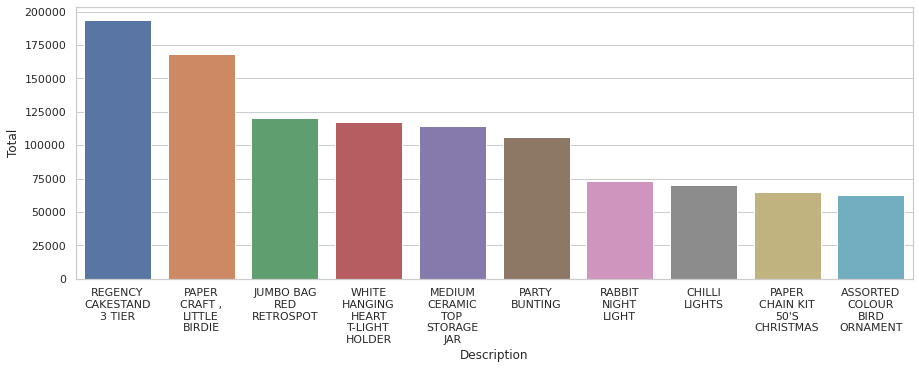

In [16]:
invoices_grouped = invoices_grouped.query('StockCode != "M" and StockCode != "DOT" and StockCode != "POST"')
plt.figure(figsize=(15,5))
ax = sns.barplot(data = invoices_grouped.head(10), x = 'Description', y = 'Total')
wrap_labels(ax, 10)
plt.show()

According to the graph above, the products *Regency cakestand 3 tier* and *Papercraft little birdie* are the top-sellers by far, will the case still be the same when we check for demand? or even when we check for top-sellers including returns and cancellations? We'll know more about it soon!

#### Products with highest demand

Products with highest demand are simply products that are bought in the highest quantities. Keep in mind in this test we are only checking purchases, not including returns or cancellations therefore this study isn't inclusive, we are just getting to know our products.

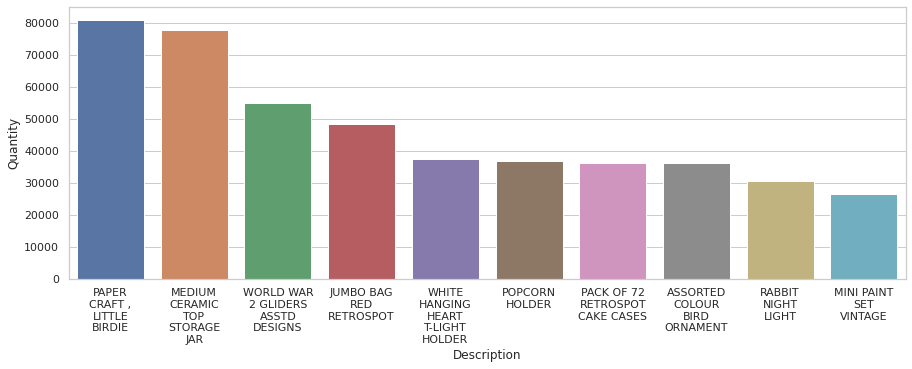

In [17]:
data = invoices_grouped.sort_values(by='Quantity', ascending = False).head(10) # sorting the table from above by quantity rather than total
plt.figure(figsize=(15,5))
ax = sns.barplot(data = data, x = 'Description', y = 'Quantity')
wrap_labels(ax, 10)
plt.show()

We can see a-lot of the products with the top sales in the highest demands graph as well - this is makes alot of sense. But where did our top seller from above (*Regency cakestand 3 tier*) disappear?

- Well top-sellers are one of 3 categories;
1. High demand and high price - this is the best!
2. Low demand and high price - *Regency cakestand 3 tier* is an example
3. High demand and cheap price - *Papercraft little birdie* is an example

That's why the product *Regency cakestand 3 tier* doesn't appear in the high demand products.

#### Returns and cancellations

In [18]:
returns_grouped = returns.groupby(['StockCode', 'Description']).agg({'UnitPrice':'mean', 'Quantity':'sum'}).reset_index()
returns_grouped['Total'] = np.floor(returns_grouped['UnitPrice'] * returns_grouped['Quantity'] * 100)/100
returns_grouped.sort_values(by='Total', ascending = True, inplace=True)
returns_grouped.head(20)

,StockCode,Description,UnitPrice,Quantity,Total
1972,M,Manual,575.172869,-4066,-2338652.89
1966,AMAZONFEE,AMAZON FEE,7352.549688,-32,-235281.60
1529,23843,"PAPER CRAFT , LITTLE BIRDIE",2.080000,-80995,-168469.60
1270,23166,MEDIUM CERAMIC TOP STORAGE JAR,1.166000,-74494,-86860.01
1970,D,Discount,72.484545,-1194,-86546.55
1688,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,1.920000,-9376,-18001.92
1973,POST,POSTAGE,90.446349,-147,-13295.62
723,22423,REGENCY CAKESTAND 3 TIER,11.980000,-855,-10242.91
1969,CRUK,CRUK Commission,495.839375,-16,-7933.43
1967,BANK CHARGES,Bank Charges,293.625600,-25,-7340.64


What we could see in the invoices dataframe, we can see in the returns dataframe as well; services that need to be dropped. Other than the original services we saw already we also see:
1. AMAZONFEE - obviously some sort of fee for AMAZON - not a product.
2. CRUK - After searching in google, this turns out to be a charity in the name of **Cancer Research UK** - not a product.
3. BANK CHARGES - Obviously not a product.

Therefore, to continue, we need to drop these items:

In [19]:
droplist = ['M', 'AMAZONFEE', 'D', 'POST', 'CRUK', 'BANK CHARGES', 'S']
returns_grouped = returns_grouped.query('StockCode not in @droplist') # dropping the servies 
returns_grouped.head(10)

,StockCode,Description,UnitPrice,Quantity,Total
1529,23843,"PAPER CRAFT , LITTLE BIRDIE",2.080000,-80995,-168469.60
1270,23166,MEDIUM CERAMIC TOP STORAGE JAR,1.166000,-74494,-86860.01
1688,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,1.920000,-9376,-18001.92
723,22423,REGENCY CAKESTAND 3 TIER,11.980000,-855,-10242.91
1859,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.807143,-2578,-7236.82
133,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,1.663333,-3150,-5239.50
1595,48185,DOORMAT FAIRY CAKE,7.650000,-674,-5156.10
1578,47566B,TEA TIME PARTY BUNTING,3.614286,-1424,-5146.75
1230,23113,PANTRY CHOPPING BOARD,5.001667,-946,-4731.58
158,21175,GIN + TONIC DIET METAL SIGN,2.282857,-2030,-4634.20


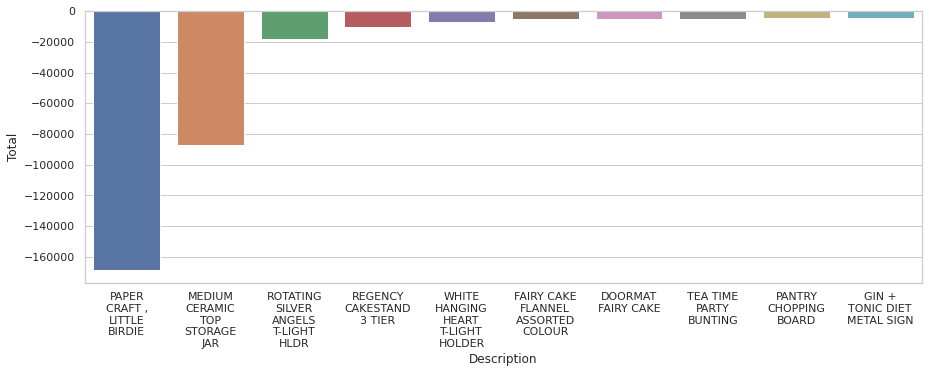

In [20]:
plt.figure(figsize=(15,5))
ax = sns.barplot(data = returns_grouped.head(10), x = 'Description', y = 'Total')
wrap_labels(ax, 10)
plt.show()

**Woah!** who would've expected that a top-seller (PAPERCRAFT LITTLE BIRDIE) would've had such return/cancellation rate? It seems like almost all sales were cancelled for this product. However, something feels fishy here, we'll have to ask the developers for this.

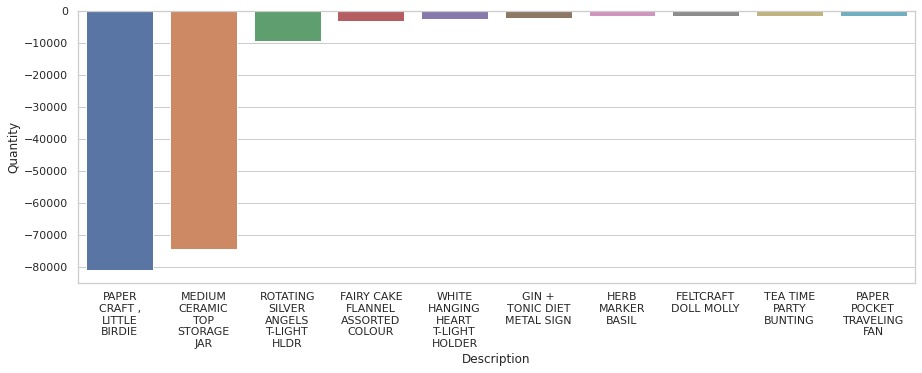

In [21]:
data = returns_grouped.sort_values(by = 'Quantity').head(10)
plt.figure(figsize=(15,5))
ax = sns.barplot(data = data, x = 'Description', y = 'Quantity')
wrap_labels(ax, 10)
plt.show()

To find the ultimate top-sellers, this time, we will have to consider everything - purchases, cancellations - at the same time - only then we'll know the real top-sellers.

In [22]:
invoices_returns_grouped = df.groupby(['Description', 'StockCode']).agg({'Quantity':'sum', 'UnitPrice':'mean'}).reset_index()
droplist = ['B', 'DOT', 'M', 'AMAZONFEE', 'D', 'POST', 'CRUK', 'BANK CHARGES', 'S']
invoices_returns_grouped = invoices_returns_grouped.query('StockCode not in @droplist')
invoices_returns_grouped['Total'] = np.floor(invoices_returns_grouped['UnitPrice'] * invoices_returns_grouped['Quantity'] * 100)/100
invoices_returns_grouped = invoices_returns_grouped.sort_values(by = 'Total', ascending = False).head(10)

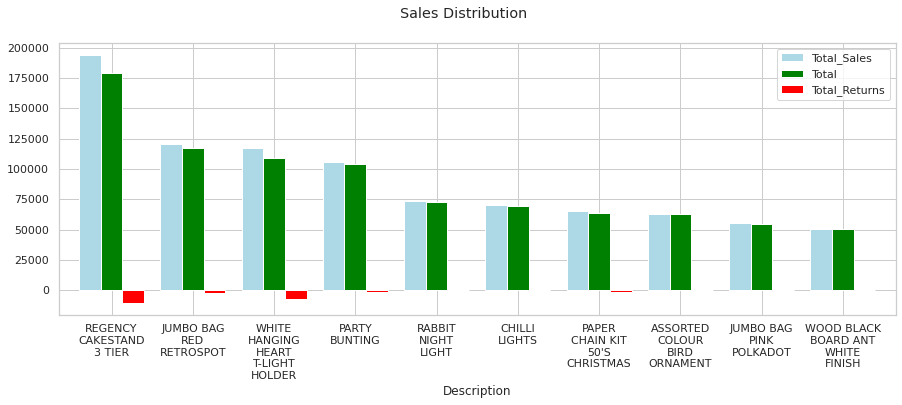

In [23]:
data_1 = invoices_returns_grouped.head(10) # 10 top sellers

data_2 = invoices_grouped[invoices_grouped['Description'].isin(data_1['Description'])].head(10) # 10 top sellers without returns
data_2 = data_2.rename(columns = {'Total':'Total_Sales', 'Quantity':'Quantity_Sales'})[['Description', 'Total_Sales', 'Quantity_Sales']]

data_3 = returns_grouped[returns_grouped['Description'].isin(data_1['Description'])].head(10) # 10 top returns
data_3 = data_3.rename(columns = {'Total':'Total_Returns', 'Quantity':'Quantity_Returns'})[['Description', 'Total_Returns', 'Quantity_Returns']]

data = data_1[['Description','Quantity', 'Total']].merge(data_2, how = 'inner', on='Description')
data = data.merge(data_3, how ='inner', on ='Description')

# found about bar width at: https://www.tutorialkart.com/matplotlib-tutorial/matplotlib-pyplot-bar-plot-width/#:~:text=To%20set%20width%20for%20bars%20in%20a%20Bar%20Plot%20using,for%20width%20parameter%20is%200.8.
ax = data.plot.bar(x = 'Description' , y = ['Total_Sales', 'Total', 'Total_Returns'], figsize = (15,5), width = 0.8, color = ['lightblue', 'green', 'red'])
wrap_labels(ax, 10)
plt.suptitle('Sales Distribution')
plt.show()

As we expected, with the amount of cancellations the product *PAPERCRAFT LITTLE BIRDIE* had, it is no surprise we don't see it making the final line of top-sellers (It wasn't the only product though, we notice there's another products that didn't make it here) - while on the other hand, *Regency cakestand 3 tier* still made it to **spot 1** even with all the cancellations it had.

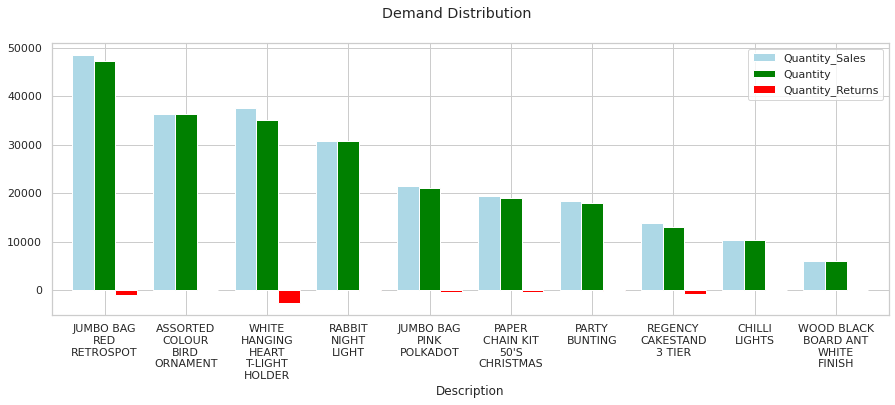

In [24]:
data = data.sort_values(by = 'Quantity', ascending = False)
ax = data.plot.bar(x = 'Description' , y = ['Quantity_Sales', 'Quantity', 'Quantity_Returns'], figsize = (15,5), width = 0.8, color = ['lightblue', 'green', 'red'])
wrap_labels(ax, 10)
plt.suptitle('Demand Distribution')
plt.show()

Following **our first study** on keyword, we can see **Red Bags** and **Pink Bags** are among the final line of top-sellers, just like we noticed on most popular keywords (we had the keywords; red, pink, bag).

Also notice that the keyword **SET** was the most popular in our first study, but it doesn't appear here. This means that our theory about vast categories with average products is correct! The keyword or category itself is very popular but none of its products are popular or a high demand product, these products are average products but as a whole category, they are very successful!

#### Summary

We've studied alot about our product range in this part, and here are the fruits of our studies:
1. The keywords; *set*, *bag*, *red*, *white*, *metal*, *chirstmas* and *cases* are among the most popular product keywords/categories.
2. Our data includes information not only about products, but also about services and charties - such as; Postage or manual services and cancer related charties.
3. The products *Papercraft little birdie* and *Medium ceramic top storage jar* had very high demand/sales but on the other hand extremely high returns/cancellation.
4. *Regency cakestand 3 tier* and *Jumbo bag red retrospot* are our final top-seller products, among other products.
5. *Jumbo bag red retrospot* and *Assorted color bird ornament* are the highest demand products we have - among other products!

In [25]:
# we dont need to following rows
invoices = invoices[(invoices['Description'] != 'PAPER CRAFT , LITTLE BIRDIE') & (invoices['Description'] != 'MEDIUM CERAMIC TOP STORAGE JAR')]
df = df[(df['Description'] != 'PAPER CRAFT , LITTLE BIRDIE') & (df['Description'] != 'MEDIUM CERAMIC TOP STORAGE JAR')]

**Next:** we'll study our customer base.
### Customer-base Analysis

We'll start our customer base analysis by grouping customers in cohorts by thier first invoice.

In [26]:
# to ensure that we're working with product rows only
droplist = ['B', 'DOT', 'M', 'AMAZONFEE', 'D', 'POST', 'CRUK', 'BANK CHARGES', 'S']
df = df.query('StockCode not in @droplist')
df = df[~df['CustomerID'].isna()] # since we are going to study customers, we need to deal with missing values

At this point, we know that missing customer ids are due to an error for new joiners - since we can't know which date their invoice happened and in order to conduct a study on our customer base, we had to drop all the rows missing a customer id.

#### Retention rates

In [27]:
df['Month'] = df['InvoiceDate'].astype('datetime64[M]') # adding a month column
df_grouped = df.groupby('CustomerID')['Month'].min().apply(lambda x: x.strftime('%Y-%m')).reset_index()
df_grouped = df_grouped.rename(columns={'Month':'CohortGroup'})
df = df.merge(df_grouped, how='left', on='CustomerID') # adding a cohort group column
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Month,CohortGroup
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850.0,2018-11-01,2018-11
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850.0,2018-11-01,2018-11
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850.0,2018-11-01,2018-11
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850.0,2018-11-01,2018-11
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850.0,2018-11-01,2018-11
...,...,...,...,...,...,...,...,...,...
399578,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2019-12-07 12:50:00,0.85,12680.0,2019-12-01,2019-08
399579,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2019-12-07 12:50:00,2.10,12680.0,2019-12-01,2019-08
399580,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2019-12-07 12:50:00,4.15,12680.0,2019-12-01,2019-08
399581,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2019-12-07 12:50:00,4.15,12680.0,2019-12-01,2019-08


In [28]:
df['Cohort'] = ((pd.to_datetime(df['Month']) - pd.to_datetime(df['CohortGroup'])) / np.timedelta64(1,'M')).round().astype('int')
df.tail(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Month,CohortGroup,Cohort
399578,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2019-12-07 12:50:00,0.85,12680.0,2019-12-01,2019-08,4
399579,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2019-12-07 12:50:00,2.10,12680.0,2019-12-01,2019-08,4
399580,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2019-12-07 12:50:00,4.15,12680.0,2019-12-01,2019-08,4
399581,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2019-12-07 12:50:00,4.15,12680.0,2019-12-01,2019-08,4
399582,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2019-12-07 12:50:00,4.95,12680.0,2019-12-01,2019-08,4


Judging by the dataframe above, everything is working fine. Lets calculate retention rates:

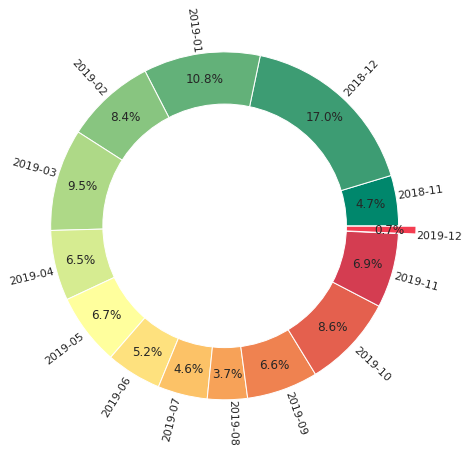

In [29]:
cohort_groups = df.groupby('CohortGroup')['CustomerID'].nunique().reset_index()
explode = (0,0,0,0,0,0,0,0,0,0,0,0,0,0.1)
# color hexes from: https://learnui.design/tools/data-color-picker.html#divergent
colors = ['#00876c','#3d9c73','#63b179','#88c580','#aed987','#d6ec91','#ffff9d','#fee17e','#fcc267','#f7a258','#ef8250','#e4604e','#d43d51','#f43d51']
plt.figure(figsize = (8,8))
ax = plt.pie(cohort_groups['CustomerID'], labels = cohort_groups['CohortGroup'], autopct='%1.1f%%', rotatelabels = True, explode = explode, colors = colors, labeldistance = 1, pctdistance = 0.85)
# source: https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f
cc = plt.Circle((0,0), 0.7, fc='white')
fig = plt.gcf()
fig.gca().add_artist(cc)
plt.show()

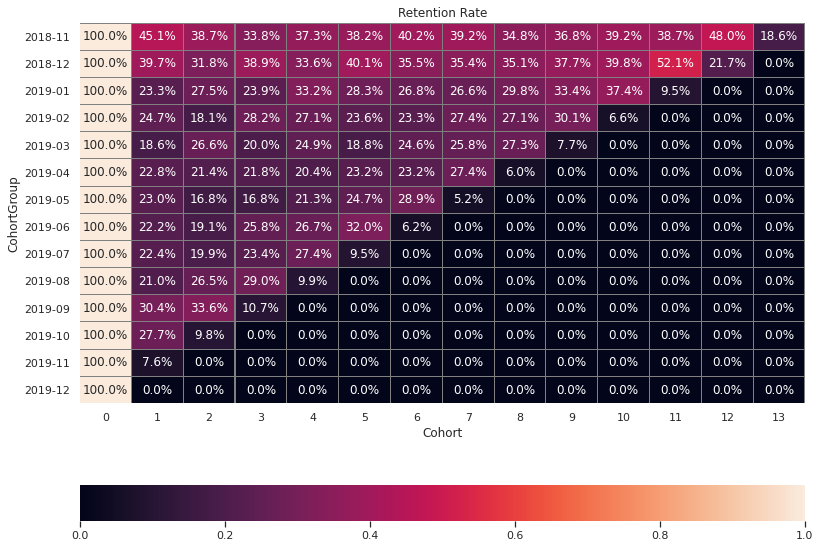

In [30]:
cohorts = df.pivot_table(index='CohortGroup', columns='Cohort', values='CustomerID', aggfunc='nunique').fillna(0)
retention = cohorts.iloc[:,0:].div(cohorts[0], axis=0)
plt.figure(figsize = (13,10))
sns.heatmap(data = retention, annot = True, fmt='.1%', linewidths=0.1, linecolor='grey', cbar_kws= {'orientation': 'horizontal'} 
            ).set(title = 'Retention Rate')
plt.show()

Looking at the heatmap, we can see a pattern of decreasing retention rate as we go down in cohort groups. The most loyal customers are customers of cohort groups 2018-11 and 2018-12 and they have the highest retention rates. Besides, the cohort group 2018-12 is the biggest cohort group among the groups.

Therefore, we decided to study the customers of the cohort group 2018-12 and see some of their behaviours.

#### Cohort Group 2018-12 Breakdown

In [31]:
cohort_group_1218 = df[df['CohortGroup'] == '2018-12'] # filtering the data to keep only the needed cohort group
grouped_1218 = cohort_group_1218.groupby('Month').agg({'CustomerID':'count', 'Quantity':'sum', 'UnitPrice':'mean'}).reset_index()
grouped_1218['Total'] = np.floor(grouped_1218['UnitPrice'] * grouped_1218['Quantity'] * 100)/100 
grouped_1218

,Month,CustomerID,Quantity,UnitPrice,Total
0,2018-12-01,19033,198818,3.107641,617855.06
1,2019-01-01,8742,121968,3.094337,377410.03
2,2019-02-01,6522,92768,2.996717,277999.46
3,2019-03-01,8496,123445,2.949466,364096.78
4,2019-04-01,7094,91410,2.802082,256138.31
5,2019-05-01,9182,142837,2.988102,426811.48
6,2019-06-01,7991,112268,2.998411,336625.57
7,2019-07-01,8162,122201,2.699637,329898.38
8,2019-08-01,9014,160237,2.725206,436678.88
9,2019-09-01,9040,158475,2.820725,447014.32


In [32]:
print('Quantity per customer:\n', grouped_1218['Quantity']/grouped_1218['CustomerID'])

Quantity per customer:
 0     10.445962
1     13.951956
2     14.223858
3     14.529779
4     12.885537
5     15.556197
6     14.049305
7     14.971943
8     17.776459
9     17.530420
10    17.702922
11    13.405605
12    15.390231
dtype: float64


In [33]:
print('Sales per customer:\n', grouped_1218['Total']/grouped_1218['CustomerID'])

Sales per customer:
 0     32.462305
1     43.172046
2     42.624879
3     42.855082
4     36.106331
5     46.483498
6     42.125588
7     40.418816
8     48.444517
9     49.448487
10    50.534867
11    37.162985
12    39.363528
dtype: float64


What we can understand from the information above about our subject cohort:
1. The average quantity per month per customer was around 14.
2. The average sales per month per customer was around 41.6 USD
3. The customers were consistent, the average quantity per user and sales per user didn't change much along the whole year.

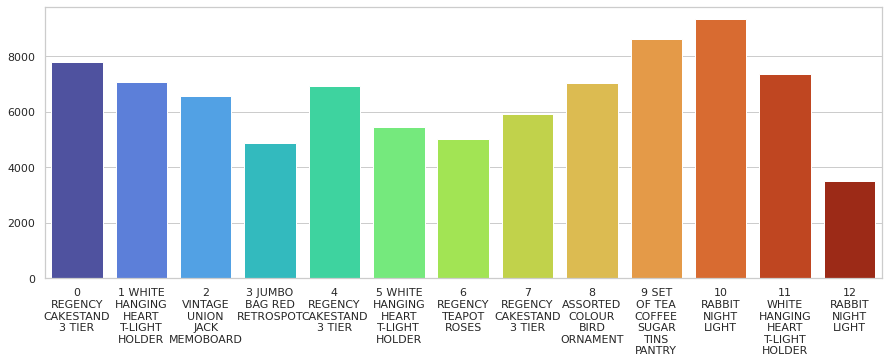

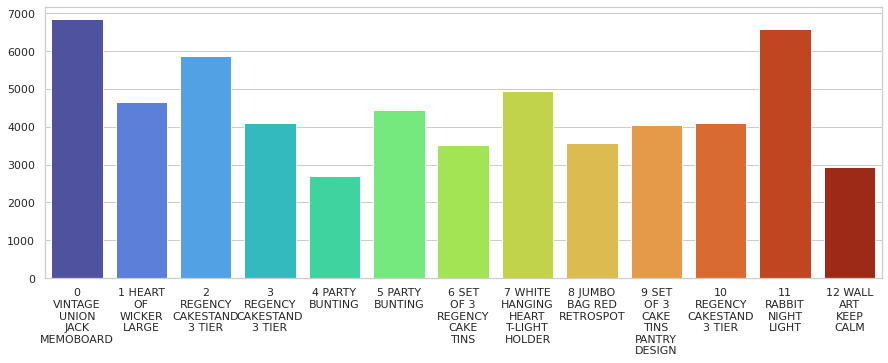

In [34]:
descs = [] 
totals = []
for i,month in enumerate(cohort_group_1218['Month'].unique()):
    cohort = cohort_group_1218[cohort_group_1218['Month'] == month]
    cohort['Total'] = np.floor(cohort['UnitPrice'] * cohort['Quantity'] * 100)/100 
    cohort_desc_grouped = cohort.groupby("Description")['Total'].sum().reset_index().sort_values(by = 'Total', ascending = False).reset_index(drop = True)
    descs.append([str(i) + " " + cohort_desc_grouped.iloc[0]['Description'],str(i) + " " + cohort_desc_grouped.iloc[1]['Description']])
    totals.append([cohort_desc_grouped.iloc[0]['Total'],cohort_desc_grouped.iloc[1]['Total']])
    
plt.figure(figsize = (15,5))    
ax = sns.barplot(x = [row[0] for row in descs], y = [row[0] for row in totals] ,palette = 'turbo')
wrap_labels(ax, 7)
plt.show()
plt.figure(figsize = (15,5))
ax = sns.barplot(x = [row[1] for row in descs], y = [row[1] for row in totals] ,palette = 'turbo')
wrap_labels(ax, 7)
plt.show()

The graph above shows the two products that was bought the most by our subject group in every month. Here we don't see anything special, this group spent their money on similar products as everyone else.

#### Summary

Our main study of the customer base was to detect habits or behaviors of our most loyal customers, what causes them to keep coming back to our store and buy more stuff in order to learn how can we cause other customers to display similar behaviours.

* First we divided our customer base into cohort groups, by their first purchase.
* Then we checked the sizes of each cohort group, we found out that the cohort group of 2018-12 was the biggest group by far, 17% of our customer base.
* We studied the retention rates of our cohort groups, turns out that the cohort groups 2018-11/12 are the groups with highest retention rates.
* Cohort group 2018-12 is the biggest and is among the highest in retention rates, thus we decided to study the habits and behaviours of it's customers.
* The customers in this group averaged at 14 products (in quantity) and 41.6 USD per month.
* They also showed consistency in their purchases - This means that the average quantity per user per month and average sales per user per month didn't change alot during the year.
* With an average of 14 items and 41.6 USD per month, this suggests that the customers bought cheap products at most (3 USD per item in average).
* During the year, each month, the customers kept coming back to buy the same products - this explains their consistency - This is shown in the graphs above, where we can see that the same products keep taking the top-sellers spots again and again every month.

## Hypotheses Testing

At this part we'll discuss and test a couple hypotheses and see whether they are actually true or not.

### First Hypothesis

To answer the question; What stock categories are more profitable? (cheap & high demand, expensive and normal demand) we'll have to get two samples of our invoices - one of each category.

Null hypothesis (H0): The distribution of cheap-high-demand products and expensive-normal-demand products' revenue is similar.

Alt. hypothesis (H1): The distribution of cheap-high-demand products and expensive-normal-demand products' revenue is different.

In [35]:
df_grouped = df.groupby(['Description', 'StockCode']).agg({'UnitPrice':'mean', 'Quantity':'sum'}).reset_index()
df_grouped['Total'] = np.floor(df_grouped['UnitPrice'] * df_grouped['Quantity'] * 100)/100
df_grouped[['UnitPrice', 'Quantity']].describe()

,UnitPrice,Quantity
count,3908.000000,3908.000000
mean,3.552844,1246.363101
std,12.380760,2778.091743
min,0.001000,-1475.000000
25%,1.006607,51.000000
50%,1.950000,327.000000
75%,3.868060,1278.000000
max,649.500000,53119.000000


We can see that 75% of our products are below 4 USD and 1300 in quantity sold. We can use these information to extract the two categories we need to test from it.

A relatively cheap product is a product sold for a price less than at least 50% of the products, on the other hand; an expensive product is a product sold at a price higher than 75% of the products. Similarly, a high demand product is a product we would find in the 70-100% of the most sold products, while a normal demand product is a product found between 70-40% of most sold products.

Therefore, we'll define our groups as follows:
1. Cheap-high-demand: less than 2 usd and demand higher than 2000
2. Expensive-normal-demand: more than 4 usd and demand between 2000 and 300

In [36]:
cheap_hi = df_grouped[(df_grouped['UnitPrice'] <= 2) & (df_grouped['Quantity'] >= 2000)]
print('Cheap-high-demand cumulative sales:', cheap_hi['Total'].sum())

Cheap-high-demand cumulative sales: 2326871.47


In [37]:
expensive_normal = df_grouped[(df_grouped['UnitPrice'] > 4) & (df_grouped['Quantity'] <= 2000) & (df_grouped['Quantity'] > 200)]
print('Expensive-normal-demand cumulative sales:', expensive_normal['Total'].sum())

Expensive-normal-demand cumulative sales: 1463780.1600000001


Now that we have our samples ready, lets test their distributions. To check if there's a significant difference between the categories, we are going to use the **The Wilcoxon-Mann-Whitney Nonparametric Test**:

In [38]:
alpha = .05 #significance level

results = st.mannwhitneyu(cheap_hi['Total'], expensive_normal['Total'])

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Null hypothesis rejected: the difference is statistically significant")
else:
    print("Failed to reject the null hypothesis: we can't make conclusions about the difference") 

p-value:  0.49606158643161735
Failed to reject the null hypothesis: we can't make conclusions about the difference


The test failed to reject the null-hypothesis. This means that we can't conclude that the distributions of cheap-high-demand and expensive-normal-demand products are different. We already know from the cumulative sales that cheap-high-demand brings in more total profit but on the other hand we can't say that there's a significant difference between the distributions of the two categories!

### Second Hypothesis

One to increase profits is to increase the revenue, but that's not the only way! Alternatively, we can lower the expenses. How would we do that? By lowering return rates. For that, we are going to study return rates in different categories:

1. High demand category
2. Low demand category

Null Hypothesis (H0): The distribution of high demand vs low demand return rates is similar.

Alt. Hypothesis (H1): The distribution of high demand vs low demand return rates is different.

In [39]:
high_demand = df_grouped[df_grouped['Quantity'] >= 2000]
low_demand = df_grouped[df_grouped['Quantity'] < 200]
high_demand_stockcodes = [code for code in high_demand['StockCode'].unique()]
low_demand_stockcodes = [code for code in low_demand['StockCode'].unique()]
high_demand = returns_grouped[returns_grouped['StockCode'].isin(high_demand_stockcodes)]
low_demand = returns_grouped[returns_grouped['StockCode'].isin(low_demand_stockcodes)]
print('Total high demand products return quantites:', high_demand['Quantity'].sum(), "- Expenses: {:.2f}$".format(high_demand['Total'].sum()))
print('Total low demand products return quantites:', low_demand['Quantity'].sum(), "- Expenses: {:.2f}$".format(low_demand['Total'].sum()))


Total high demand products return quantites: -68867 - Expenses: -135258.84$
Total low demand products return quantites: -20251 - Expenses: -62804.33$


In [40]:
alpha = .05 #significance level

results = st.mannwhitneyu(high_demand['Quantity'], low_demand['Quantity'])

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Null hypothesis rejected: the difference is statistically significant")
else:
    print("Failed to reject the null hypothesis: we can't make conclusions about the difference") 

p-value:  8.41266753330034e-82
Null hypothesis rejected: the difference is statistically significant


The test rejected the null hypothesis - thus proving that there is a significant difference between the distributions of returns among high demand and low demand products.

Looks like high demand products' returns are in much much higher rates and as we saw above, it costs much more in expenses for the company - This result is very reasonable since high demand products are bought in higher rates so we should also expect higher rates in returns/cancellations as well.

## General Summary

### Pre-EDA Points & Summary
* We have around 134,000 of missing values in CustomerID - according to the team lead, this happened due to an error in the system for new users - we kept the rows because we still have InvoiceNo's in the other hand to identify the row.
* Seperated the dataset into 2 main dataframes; Invoices (purchases) and Returns for easier working later on.
* We've cut deep memory_usage from 157 MB to 97 MB - 60 MB saved!
* We've dropped 5,000 duplicates and dealt with 12,000 missing values.

### EDA Points & Summary
1. Product Range Values & Categorization Analysis

we successfully found popular keywords that appeared within the invoices. Categories like **Red**, **Blue**, **White**, **Cake**, **Bag** or **Metal** appeared to be among the top keywords/categories. This could be due to this categories actually being popular or simply due to having on overly-popular product with-in this category. After the continuation of the research, we found out that we have categories of both types - This gives a reason for the research, because otherwise it is unnecessary!
* Our data includes information not only about products, but also about services and charties - such as; Postage or manual services and cancer related charties.
* The products Papercraft little birdie and Medium ceramic top storage jar had very high demand/sales but on the other hand extremely high returns/cancellation.
* Regency cakestand 3 tier and Jumbo bag red retrospot are our final top-seller products, among other products.
* Jumbo bag red retrospot and Assorted color bird ornament are the highest demand products we have - among other products!

2. Customer base analysis

Our main study of the customer base was to detect habits or behaviors of our most loyal customers, what causes them to keep coming back to our store and buy more stuff in order to learn how can we cause other customers to display similar behaviours.

* We divided our customer base into cohort groups, by their first purchase. Then we checked the sizes of each cohort group, we found out that the cohort group of 2018-12 was the biggest group by far, 17% of our customer base.
* We studied the retention rates of our cohort groups, turns out that the cohort groups 2018-11/12 are the groups with highest retention rates.
* Cohort group 2018-12 is the biggest and is among the highest in retention rates, thus we decided to study the habits and behaviours of it's customers.
* The customers in this group averaged at 14 products (in quantity) and 41.6 USD per month.
* They also showed consistency in their purchases - This means that the average quantity per user per month and average sales per user per month didn't change alot during the year.
* With an average of 14 items and 41.6 USD per month, this suggests that the customers bought cheap products at most (3 USD per item in average).
* During the year, each month, the customers kept coming back to buy the same products - this explains their consistency - This is shown in the graphs above, where we can see that the same products keep taking the top-sellers spots again and again every month.

### Post-EDA Points & Summary
This part discusses two hypotheses - we used the Mann-Whitney-U test to test similarties between distributions of different samples:

1. Null Hypothesis (H0): The distribution of cheap-high-demand products and expensive-normal-demand products' revenue is similar:
* Cheap-high-demand: less than 2 usd and demand higher than 2000
* Expensive-normal-demand: more than 4 usd and demand between 2000 and 300
* The test failed to reject the null-hypothesis. This means that we can't conclude that the distributions of cheap-high-demand and expensive-normal-demand products are different. We already know from the cumulative sales that cheap-high-demand brings in more total profit but on the other hand we can't say that there's a significant difference between the distributions of the two categories!
2. The distribution of high demand vs low demand return rates is similar:
* The test rejected the null hypothesis - thus proving that there is a significant difference between the distributions of returns among high demand and low demand products.
* High demand products' returns have much much higher rates. It costs much more in expenses for the company as well - This result is very reasonable since high demand products are bought in higher rates so we should also expect higher rates in returns/cancellations as well.